In [218]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime
from geopy.distance import geodesic
import math
import seaborn as sns

from scipy import stats
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, spearmanr, chi2_contingency
from scipy.spatial import cKDTree

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split



In [219]:
bikes = pd.read_csv("C:/Users/Laura/Downloads/DSML/Project/bluebikes_2021.csv")
weather = pd.read_csv("C:/Users/Laura/Downloads/DSML/Project/boston_weather.csv")
pois = pd.read_csv("C:/Users/Laura/Downloads/DSML/Project/pois.csv")

C:\Users\Laura\AppData\Local\Temp\ipykernel_5072\4071934133.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  bikes = pd.read_csv("C:/Users/Laura/Downloads/DSML/Project/bluebikes_2021.csv")
C:\Users\Laura\AppData\Local\Temp\ipykernel_5072\4071934133.py:3: DtypeWarning: Columns (10,12,13,14,21,22,25,26,28,29,31,32,33,34,35,36,37,39,40,41,43,44,45,48,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,74,75,76,77,78,79,80,81,82,84,85,88,89,90,91,92,93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  pois = pd.read_csv("C:/Users/Laura/Downloads/DSML/Project/pois.csv")


# Data Collection and Preparation


## Bluebikes 

In [220]:
bikes.info()
bikes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2934388 entries, 0 to 2934387
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   start_time         object 
 2   end_time           object 
 3   start_station_id   int64  
 4   start_station_lat  float64
 5   start_station_lon  float64
 6   end_station_id     object 
 7   end_station_lat    float64
 8   end_station_lon    float64
 9   bike_id            int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 223.9+ MB


,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id
0,0,2021-01-01 00:00:04,2021-01-01 00:15:19,91,42.366277,-71.091690,370,42.350961,-71.077828,5316
1,1,2021-01-01 00:00:21,2021-01-01 00:18:27,370,42.350961,-71.077828,169,42.378965,-71.068607,4917
2,2,2021-01-01 00:00:26,2021-01-01 00:16:12,46,42.343666,-71.085824,21,42.346520,-71.080658,2881
3,3,2021-01-01 00:00:30,2021-01-01 00:06:26,178,42.359573,-71.101295,107,42.362500,-71.088220,4792
4,4,2021-01-01 00:01:11,2021-01-01 00:09:43,386,42.368605,-71.099302,413,42.369553,-71.085790,6062
...,...,...,...,...,...,...,...,...,...,...
2934383,2934373,2021-12-31 23:58:38,2022-01-01 00:06:38,4,42.345392,-71.069616,415,42.349544,-71.072421,4895
2934384,2934374,2021-12-31 23:58:46,2022-01-01 00:11:24,77,42.386844,-71.098120,96,42.373379,-71.111075,3665
2934385,2934375,2021-12-31 23:58:49,2022-01-01 00:03:30,338,42.348359,-71.139972,8,42.353334,-71.137313,6470
2934386,2934376,2021-12-31 23:59:50,2022-01-01 00:01:49,32,42.343691,-71.102353,19,42.347241,-71.105301,6484


#### Change 'start_time' and 'end_time' from object to datetime

In [221]:
# We want to change the data type of the variables start_time and end_time from objects to datetime
# In order to do that first we have to deal with the inconsistencies in the columns start_time and end_time 
# Some of the entries don't follow the format year-month-day; hours:minutes:seconds, so we need to change the format
# by creating a function that replaces the slashes (/) with colons (:) of some values 

def substitute_slashes(data, column):
    data[column] = data[column].str.replace('/', ':')
    return data

substitute_slashes(bikes, 'start_time')
substitute_slashes(bikes, 'end_time')

,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id
0,0,2021-01-01 00:00:04,2021-01-01 00:15:19,91,42.366277,-71.091690,370,42.350961,-71.077828,5316
1,1,2021-01-01 00:00:21,2021-01-01 00:18:27,370,42.350961,-71.077828,169,42.378965,-71.068607,4917
2,2,2021-01-01 00:00:26,2021-01-01 00:16:12,46,42.343666,-71.085824,21,42.346520,-71.080658,2881
3,3,2021-01-01 00:00:30,2021-01-01 00:06:26,178,42.359573,-71.101295,107,42.362500,-71.088220,4792
4,4,2021-01-01 00:01:11,2021-01-01 00:09:43,386,42.368605,-71.099302,413,42.369553,-71.085790,6062
...,...,...,...,...,...,...,...,...,...,...
2934383,2934373,2021-12-31 23:58:38,2022-01-01 00:06:38,4,42.345392,-71.069616,415,42.349544,-71.072421,4895
2934384,2934374,2021-12-31 23:58:46,2022-01-01 00:11:24,77,42.386844,-71.098120,96,42.373379,-71.111075,3665
2934385,2934375,2021-12-31 23:58:49,2022-01-01 00:03:30,338,42.348359,-71.139972,8,42.353334,-71.137313,6470
2934386,2934376,2021-12-31 23:59:50,2022-01-01 00:01:49,32,42.343691,-71.102353,19,42.347241,-71.105301,6484


In [222]:
# Now we can transform the start_time and end_time columns to the proper format with the pd.to_datatime method

bikes[['start_time','end_time']] = bikes[['start_time','end_time']].apply(pd.to_datetime)

In [223]:
# We can use the info() method to assure that the data types of the variables start_time and end_time have been changed

bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2934388 entries, 0 to 2934387
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Unnamed: 0         int64         
 1   start_time         datetime64[ns]
 2   end_time           datetime64[ns]
 3   start_station_id   int64         
 4   start_station_lat  float64       
 5   start_station_lon  float64       
 6   end_station_id     object        
 7   end_station_lat    float64       
 8   end_station_lon    float64       
 9   bike_id            int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(1)
memory usage: 223.9+ MB


#### Change 'end_station_id' to integer

In [224]:
# We also want to change the data type of the variable end_station_id to an integer (it should be the same as start_station_id)
# This inconsistency is because some of the values in the column end_station_id are not in the proper format,
# instead of being whole numers some of them have quote symbols (""), which makes transform the column into an object type
# We create a function that eliminates the quote marks of the numbers

def remove_quotes(data, column):
    data[column] = data[column].apply(lambda x: x.replace('"', '') if isinstance(x, str) else x)
    return data

bikes = remove_quotes(bikes, 'end_station_id')

In [225]:
# Once all the values in the column have the same format then we can proceed to transform the data type of the variable to integer

bikes['end_station_id'] = bikes['end_station_id'].apply('int64')

In [226]:
# We can use the info() method to confirm that the type of the variable 'end_station_id' has been changed

bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2934388 entries, 0 to 2934387
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Unnamed: 0         int64         
 1   start_time         datetime64[ns]
 2   end_time           datetime64[ns]
 3   start_station_id   int64         
 4   start_station_lat  float64       
 5   start_station_lon  float64       
 6   end_station_id     int64         
 7   end_station_lat    float64       
 8   end_station_lon    float64       
 9   bike_id            int64         
dtypes: datetime64[ns](2), float64(4), int64(4)
memory usage: 223.9 MB


#### Account for time change

In [227]:
# We want to create a new variable that contains the average idle time of a bike for each station 
# First we want to eliminate those entries with the change of hour

# We exclude the times of change of hour
start_time_range_1 = pd.Timestamp('2021-03-14 02:00:00')
end_time_range_1 = pd.Timestamp('2021-03-14 03:00:00')
start_time_range_2 = pd.Timestamp('2021-11-07 01:00:00')
end_time_range_2 = pd.Timestamp('2021-11-07 02:00:00')

# Create boolean masks to filter out the entries within the specified time ranges
mask_range_1 = (bikes['start_time'].between(start_time_range_1, end_time_range_1)) | (bikes['end_time'].between(start_time_range_1, end_time_range_1))
mask_range_2 = (bikes['start_time'].between(start_time_range_2, end_time_range_2)) | (bikes['end_time'].between(start_time_range_2, end_time_range_2))

# Apply the masks to exclude the entries within the specified time ranges
bikes = bikes[~(mask_range_1 | mask_range_2)]

#### Include the variable date in the data frame bikes 

In [228]:
bikes['date'] = bikes['start_time'].dt.date

C:\Users\Laura\AppData\Local\Temp\ipykernel_5072\1409850908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes['date'] = bikes['start_time'].dt.date


#### Calculate the duration of each trip 

In [229]:
bikes['duration'] = (bikes['end_time'] - bikes['start_time']).dt.total_seconds() / 60 
bikes

C:\Users\Laura\AppData\Local\Temp\ipykernel_5072\377344393.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes['duration'] = (bikes['end_time'] - bikes['start_time']).dt.total_seconds() / 60


,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id,date,duration
0,0,2021-01-01 00:00:04,2021-01-01 00:15:19,91,42.366277,-71.091690,370,42.350961,-71.077828,5316,2021-01-01,15.250000
1,1,2021-01-01 00:00:21,2021-01-01 00:18:27,370,42.350961,-71.077828,169,42.378965,-71.068607,4917,2021-01-01,18.100000
2,2,2021-01-01 00:00:26,2021-01-01 00:16:12,46,42.343666,-71.085824,21,42.346520,-71.080658,2881,2021-01-01,15.766667
3,3,2021-01-01 00:00:30,2021-01-01 00:06:26,178,42.359573,-71.101295,107,42.362500,-71.088220,4792,2021-01-01,5.933333
4,4,2021-01-01 00:01:11,2021-01-01 00:09:43,386,42.368605,-71.099302,413,42.369553,-71.085790,6062,2021-01-01,8.533333
...,...,...,...,...,...,...,...,...,...,...,...,...
2934383,2934373,2021-12-31 23:58:38,2022-01-01 00:06:38,4,42.345392,-71.069616,415,42.349544,-71.072421,4895,2021-12-31,8.000000
2934384,2934374,2021-12-31 23:58:46,2022-01-01 00:11:24,77,42.386844,-71.098120,96,42.373379,-71.111075,3665,2021-12-31,12.633333
2934385,2934375,2021-12-31 23:58:49,2022-01-01 00:03:30,338,42.348359,-71.139972,8,42.353334,-71.137313,6470,2021-12-31,4.683333
2934386,2934376,2021-12-31 23:59:50,2022-01-01 00:01:49,32,42.343691,-71.102353,19,42.347241,-71.105301,6484,2021-12-31,1.983333


In [230]:
# We remove major outliers from the data (trips longer than 6 hours)

bikes['duration'].quantile(0.995)
bikes = bikes[bikes.duration <= 360]

# we went from 2934388 rows to 2926307

#### Calculate peak hours

C:\Users\Laura\AppData\Local\Temp\ipykernel_5072\672720971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes['start_hour'] = bikes['start_time'].dt.hour


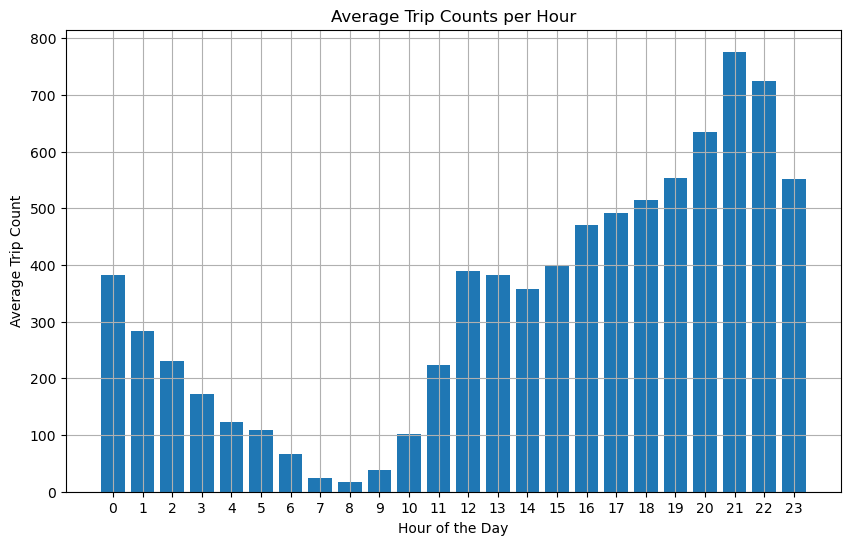

,hour,average_trip_count
0,0,382.0
1,1,284.0
2,2,231.0
3,3,173.0
4,4,123.0
5,5,109.0
6,6,66.0
7,7,25.0
8,8,17.0
9,9,38.0


In [231]:
# Step 1: Extract the hour of the day from the "start_time" column
bikes['start_hour'] = bikes['start_time'].dt.hour

# Step 2: Calculate the average number of bike trips for each hour
hourly_trip_counts = bikes.groupby('start_hour')['bike_id'].count().reset_index()
hourly_trip_counts.columns = ['hour', 'total_trip_count']

# Step 3: Calculate the average number of trips for each hour by dividing the total_trip_count by the number of days
number_of_days = bikes['start_time'].dt.date.nunique()
hourly_trip_counts['average_trip_count'] = hourly_trip_counts['total_trip_count'] / number_of_days

# Step 4: Round the average trip counts to the nearest whole number
hourly_trip_counts['average_trip_count'] = hourly_trip_counts['average_trip_count'].round()

# Step 5: Plot a bar graph to visualize the average trip counts for each hour
plt.figure(figsize=(10, 6))
plt.bar(hourly_trip_counts['hour'], hourly_trip_counts['average_trip_count'])
plt.xlabel('Hour of the Day')
plt.ylabel('Average Trip Count')
plt.title('Average Trip Counts per Hour')
plt.xticks(range(24))
plt.grid(True)
plt.show()

# Step 6: Store the average trip counts per hour in a new data frame
average_trip_count = hourly_trip_counts[['hour', 'average_trip_count']].copy()

average_trip_count

#### Create variable 'idle_time'

In [232]:
# First we need to calculate the idle time for every bike

# 1. We sort the data by bike_id and end_time
bikes.sort_values(['bike_id', 'end_time'], inplace=True)

# 2. Group the data by bike_id
grouped = bikes.groupby('bike_id')

# 3. Calculate the idle time for each bike by subtracting end_time to start_time and store in a new variable called idle_time
bikes['idle_time'] = grouped['start_time'].shift(-1) - bikes['end_time']

# 4. Set the idle time to 0 for the last bike usage
bikes.loc[grouped['bike_id'].cumcount() == grouped['bike_id'].transform('size') - 1, 'idle_time'] = pd.Timedelta(0)

# 5. Reset the dataframe index
bikes.reset_index(drop=True, inplace=True)

C:\Users\Laura\AppData\Local\Temp\ipykernel_5072\1869849024.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes.sort_values(['bike_id', 'end_time'], inplace=True)
C:\Users\Laura\AppData\Local\Temp\ipykernel_5072\1869849024.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes['idle_time'] = grouped['start_time'].shift(-1) - bikes['end_time']


In [233]:
bikes['idle_time_minutes'] = bikes['idle_time'].dt.total_seconds() / 60
bikes['idle_time_minutes'] = bikes['idle_time_minutes'].astype(int)

bikes[['bike_id', 'start_station_id','end_station_id','idle_time_minutes']]

C:\Users\Laura\AppData\Local\Temp\ipykernel_5072\2054574570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes['idle_time_minutes'] = bikes['idle_time'].dt.total_seconds() / 60
C:\Users\Laura\AppData\Local\Temp\ipykernel_5072\2054574570.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes['idle_time_minutes'] = bikes['idle_time_minutes'].astype(int)


,bike_id,start_station_id,end_station_id,idle_time_minutes
0,218,171,397,3788
1,218,397,176,374
2,218,176,76,36
3,218,76,54,69
4,218,54,56,5448
...,...,...,...,...
2925767,7665,74,333,1895
2925768,7665,333,76,7
2925769,7665,76,189,2803
2925770,7665,116,68,1


In [234]:
# Second we want to sum all the idle time for every station

# 1. Sort for end_station_id
bikes.sort_values(['end_station_id'], inplace=True)

# 2. Group the data by end_station_id and calculate the sum of idle time
station_idle_sum = bikes.groupby('end_station_id')['idle_time_minutes'].sum()

# 3. Reset the index and rename the columns
station_idle_sum = station_idle_sum.reset_index()
station_idle_sum.columns = ['station_id', 'idle_time_sum']

# Now we have the total idle time for every station
station_idle_sum

C:\Users\Laura\AppData\Local\Temp\ipykernel_5072\3955057821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes.sort_values(['end_station_id'], inplace=True)


,station_id,idle_time_sum
0,1,1187696
1,3,4228939
2,4,6979461
3,5,2924994
4,6,4716417
...,...,...
422,548,8689
423,549,1678659
424,550,167922
425,553,567219


In [235]:
# We also want the mean idle time of every station for every day, so we group the data by end_station_id 
# and calculate the average idle time
station_idle_mean = bikes.groupby('end_station_id')['idle_time'].mean()

# Reset the index and rename the columns
station_idle_mean = station_idle_mean.reset_index()
station_idle_mean.columns = ['station_id', 'idle_time_mean']

# We convert the idle time to hours 
station_idle_mean['idle_time_mean'] = (station_idle_mean['idle_time_mean'].dt.total_seconds() / 60).round()

# Now we have the mean idle time in hours for every station

station_idle_mean

,station_id,idle_time_mean
0,1,3546.0
1,3,459.0
2,4,569.0
3,5,201.0
4,6,225.0
...,...,...
422,548,1242.0
423,549,622.0
424,550,639.0
425,553,1045.0


In [236]:
# Now we want to create a data frame that contains all the station_id with their respective latitudes and longitudes and
# that then we will merge with all the idle time information

station_ids = sorted(pd.concat([bikes['start_station_id'], bikes['end_station_id']]).unique())
stations = pd.DataFrame({'station_id': station_ids})

stations['lat'] = 0.0
stations['lon'] = 0.0

for index, row in stations.iterrows():
    station_id = row['station_id']
    station_data = bikes[(bikes['start_station_id'] == station_id) | (bikes['end_station_id'] == station_id)].iloc[0]
    if station_data['start_station_id'] == station_id:
        stations.loc[index, 'lat'] = station_data['start_station_lat']
        stations.loc[index, 'lon'] = station_data['start_station_lon']
    else:
        stations.loc[index, 'lat'] = station_data['end_station_lat']
        stations.loc[index, 'lon'] = station_data['end_station_lon']  

In [237]:
# We merge all data sets into a new data frame 

stations = stations.assign(idle_time_sum=station_idle_sum['idle_time_sum'],
                           idle_time_mean=station_idle_mean['idle_time_mean'])
stations

,station_id,lat,lon,idle_time_sum,idle_time_mean
0,1,42.387151,-71.075978,1187696,3546.0
1,3,42.340115,-71.100619,4228939,459.0
2,4,42.345392,-71.069616,6979461,569.0
3,5,42.341814,-71.090179,2924994,201.0
4,6,42.361257,-71.065287,4716417,225.0
...,...,...,...,...,...
422,548,42.268100,-71.119240,8689,1242.0
423,549,42.364739,-71.059349,1678659,622.0
424,550,42.386400,-71.096010,167922,639.0
425,553,42.371141,-71.076198,567219,1045.0


In [238]:
# We want to calculate the daily average idle time for each station

# Step 2: Calculate the daily mean idle time for each station
daily_mean_idle_time = bikes.groupby(['start_station_id', 'date'])['idle_time_minutes'].mean().reset_index()

# Step 3: Calculate the mean of the daily mean idle time for each station
station_daily_mean_idle_time = daily_mean_idle_time.groupby('start_station_id')['idle_time_minutes'].mean().reset_index()

# Step 4: Merge the mean idle time with the stations data frame
stations = pd.merge(stations, station_daily_mean_idle_time, left_on='station_id', right_on='start_station_id', how='left')

# Drop the 'start_station_id' column as it is no longer needed
stations.drop(columns=['start_station_id'], inplace=True)

# Rename the new variable to 'daily_idle_time_mean'
stations.rename(columns={'idle_time_minutes': 'daily_idle_time_mean'}, inplace=True)


In [239]:
stations

,station_id,lat,lon,idle_time_sum,idle_time_mean,daily_idle_time_mean
0,1,42.387151,-71.075978,1187696,3546.0,2043.675388
1,3,42.340115,-71.100619,4228939,459.0,791.496659
2,4,42.345392,-71.069616,6979461,569.0,833.181883
3,5,42.341814,-71.090179,2924994,201.0,364.187578
4,6,42.361257,-71.065287,4716417,225.0,655.532480
...,...,...,...,...,...,...
422,548,42.268100,-71.119240,8689,1242.0,8880.000000
423,549,42.364739,-71.059349,1678659,622.0,716.782809
424,550,42.386400,-71.096010,167922,639.0,962.149411
425,553,42.371141,-71.076198,567219,1045.0,562.259964


#### Calculate the average daily trips for each station 

In [240]:
# Step 1: Calculate the total number of trips for each station in the "bikes" data frame

total_trips_per_station = bikes.groupby('start_station_id')['bike_id'].count().reset_index()
total_trips_per_station = total_trips_per_station.rename(columns={'bike_id': 'total_trips'})

# Step 2: Merge the total trips with the "stations" data frame

stations = pd.merge(stations, total_trips_per_station, left_on='station_id', right_on='start_station_id', how='left')

# Drop the duplicated station_id column after merging

stations.drop(columns=['start_station_id'], inplace=True)

stations

,station_id,lat,lon,idle_time_sum,idle_time_mean,daily_idle_time_mean,total_trips
0,1,42.387151,-71.075978,1187696,3546.0,2043.675388,246
1,3,42.340115,-71.100619,4228939,459.0,791.496659,8737
2,4,42.345392,-71.069616,6979461,569.0,833.181883,12077
3,5,42.341814,-71.090179,2924994,201.0,364.187578,14356
4,6,42.361257,-71.065287,4716417,225.0,655.532480,21212
...,...,...,...,...,...,...,...
422,548,42.268100,-71.119240,8689,1242.0,8880.000000,5
423,549,42.364739,-71.059349,1678659,622.0,716.782809,2738
424,550,42.386400,-71.096010,167922,639.0,962.149411,432
425,553,42.371141,-71.076198,567219,1045.0,562.259964,699


In [241]:
# Step 2: Calculate the total number of trips for each station for each day
total_trips_per_station_daily = bikes.groupby(['start_station_id', 'date'])['bike_id'].count().reset_index()
total_trips_per_station_daily = total_trips_per_station_daily.rename(columns={'bike_id': 'total_trips_daily'})

# Step 3: Calculate the average daily trips for each station
average_daily_trips_per_station = total_trips_per_station_daily.groupby('start_station_id')['total_trips_daily'].mean().reset_index()
average_daily_trips_per_station = average_daily_trips_per_station.rename(columns={'total_trips_daily': 'avg_daily_trips'})

# Step 4: Merge the average daily trips with the "stations" data frame
stations = pd.merge(stations, average_daily_trips_per_station, left_on='station_id', right_on='start_station_id', how='left')
stations.drop(columns=['start_station_id'], inplace=True)

stations

,station_id,lat,lon,idle_time_sum,idle_time_mean,daily_idle_time_mean,total_trips,avg_daily_trips
0,1,42.387151,-71.075978,1187696,3546.0,2043.675388,246,1.430233
1,3,42.340115,-71.100619,4228939,459.0,791.496659,8737,24.002747
2,4,42.345392,-71.069616,6979461,569.0,833.181883,12077,33.178571
3,5,42.341814,-71.090179,2924994,201.0,364.187578,14356,78.021739
4,6,42.361257,-71.065287,4716417,225.0,655.532480,21212,58.115068
...,...,...,...,...,...,...,...,...
422,548,42.268100,-71.119240,8689,1242.0,8880.000000,5,1.250000
423,549,42.364739,-71.059349,1678659,622.0,716.782809,2738,29.760870
424,550,42.386400,-71.096010,167922,639.0,962.149411,432,5.468354
425,553,42.371141,-71.076198,567219,1045.0,562.259964,699,11.095238


## Weather

In [242]:
weather.info()
weather

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82777 entries, 0 to 82776
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city                     82777 non-null  object 
 1   timestamp                82777 non-null  object 
 2   temperature              82773 non-null  float64
 3   cloud_cover              82777 non-null  int64  
 4   cloud_cover_description  82777 non-null  object 
 5   pressure                 82768 non-null  float64
 6   windspeed                82740 non-null  float64
 7   precipitation            82777 non-null  float64
 8   felt_temperature         82752 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 5.7+ MB


,city,timestamp,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,felt_temperature
0,Boston,2015-01-01 05:54:00,-6.0,29,Partly Cloudy,1018.58,17.0,0.00,-12.0
1,Boston,2015-01-01 06:54:00,-6.0,27,Mostly Cloudy,1017.90,17.0,0.00,-12.0
2,Boston,2015-01-01 07:54:00,-6.0,27,Mostly Cloudy,1017.22,19.0,0.00,-12.0
3,Boston,2015-01-01 08:54:00,-4.0,27,Mostly Cloudy,1016.55,20.0,0.00,-11.0
4,Boston,2015-01-01 09:54:00,-6.0,29,Partly Cloudy,1016.21,24.0,0.00,-13.0
...,...,...,...,...,...,...,...,...,...
82772,Boston,2023-01-01 01:54:00,12.0,11,Light Rain,1007.75,13.0,0.51,12.0
82773,Boston,2023-01-01 02:54:00,11.0,11,Light Rain,1006.73,11.0,1.78,11.0
82774,Boston,2023-01-01 03:54:00,11.0,11,Light Rain,1005.72,11.0,2.29,11.0
82775,Boston,2023-01-01 04:29:00,12.0,11,Light Rain,1005.04,15.0,0.76,12.0


In [243]:
# First we want to change the "timestamp" variable type from object to datetime with pd.to_datetime

weather['timestamp'] = pd.to_datetime(weather['timestamp'])

In [244]:
# Now we filter only the entries for the year 2021, since is the year we are interested in for our project   

weather = weather[weather['timestamp'].dt.year == 2021] 

In [245]:
# We look whether there are any null-values which we want to get rid of

missing_values = weather.isnull().sum() 
print(missing_values)

rows_with_missing_values = weather[weather.isnull().any(axis=1)]
print(rows_with_missing_values)

city                       0
timestamp                  0
temperature                2
cloud_cover                0
cloud_cover_description    0
pressure                   0
windspeed                  3
precipitation              0
felt_temperature           2
dtype: int64
         city           timestamp  temperature  cloud_cover  \
63950  Boston 2021-03-03 16:54:00          NaN           34   
66774  Boston 2021-06-17 17:54:00         25.0           34   
68871  Boston 2021-08-24 17:54:00         31.0           28   
70297  Boston 2021-10-14 17:54:00          NaN           34   

      cloud_cover_description  pressure  windspeed  precipitation  \
63950                    Fair   1008.09        NaN            0.0   
66774                    Fair   1011.81        NaN            0.0   
68871           Mostly Cloudy   1011.13        NaN            0.0   
70297                    Fair   1011.47       20.0            0.0   

       felt_temperature  
63950               NaN  
66774       

In [246]:
#  We drop all null-values and check if we successfully got rid of them

weather = weather.dropna()

missing_values = weather.isnull().sum()
print(missing_values)

city                       0
timestamp                  0
temperature                0
cloud_cover                0
cloud_cover_description    0
pressure                   0
windspeed                  0
precipitation              0
felt_temperature           0
dtype: int64


## Points of interest

In [247]:
# First we filter only the information for Boston, since we do not need the data of Massachusetts

pois = pois[pois['addr:city'] == "Boston"] 

In [248]:
pois.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908 entries, 33 to 92230
Data columns (total 96 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1908 non-null   int64  
 1   version             1908 non-null   int64  
 2   timestamp           1908 non-null   int64  
 3   changeset           1610 non-null   float64
 4   id                  1908 non-null   int64  
 5   tags                1861 non-null   object 
 6   lat                 1585 non-null   float64
 7   lon                 1585 non-null   float64
 8   addr:city           1908 non-null   object 
 9   addr:country        16 non-null     object 
 10  addr:full           1 non-null      object 
 11  addr:housenumber    1878 non-null   object 
 12  addr:housename      8 non-null      object 
 13  addr:postcode       1839 non-null   object 
 14  addr:place          1 non-null      object 
 15  addr:street         1900 non-null   object 
 16  emai

In [249]:
pois

,Unnamed: 0,version,timestamp,changeset,id,tags,lat,lon,addr:city,addr:country,...,geometry,osm_type,biergarten,theatre,agrarian,cosmetics,outdoor,swimming_pool,trade,water
33,33,6,1591763622,0.0,69504856,"{""addr:state"":""MA"",""attribution"":""massDOT"",""bu...",42.338516,-71.03127,Boston,NaN,...,POINT (-71.0312728881836 42.33851623535156),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,84,4,1530115928,0.0,257486687,"{""addr:state"":""MA"",""attribution"":""Office of Ge...",42.299590,-71.10173,Boston,NaN,...,POINT (-71.10173034667969 42.299591064453125),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,90,6,1593727122,0.0,257486695,"{""addr:state"":""MA"",""attribution"":""Office of Ge...",42.292465,-71.10141,Boston,NaN,...,POINT (-71.10140991210938 42.29246520996094),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,96,5,1596134943,0.0,257486704,"{""addr:state"":""MA"",""attribution"":""Office of Ge...",42.367275,-71.06633,Boston,NaN,...,POINT (-71.06632995605469 42.36727523803711),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,99,3,1530115932,0.0,257486710,"{""addr:state"":""MA"",""attribution"":""Office of Ge...",42.334450,-71.06774,Boston,NaN,...,POINT (-71.06774139404297 42.334449768066406),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92220,92220,10,1680275378,0.0,7547154230,"{""addr:state"":""MA"",""site"":""school"",""type"":""site""}",NaN,NaN,Boston,NaN,...,"MULTIPOLYGON (((-71.0829577 42.3490254, -71.08...",relation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92221,92221,5,1596311865,0.0,9405156098,"{""addr:state"":""MA"",""contact:facebook"":""https:/...",NaN,NaN,Boston,NaN,...,"POLYGON ((-71.0784068 42.3501667, -71.0784356 ...",relation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92222,92222,6,1638386222,0.0,9427558974,"{""addr:state"":""MA"",""type"":""multipolygon""}",NaN,NaN,Boston,NaN,...,"MULTIPOLYGON (((-71.030267 42.3720275, -71.030...",relation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92224,92224,5,1644043877,0.0,9696493087,"{""addr:state"":""MA"",""air_conditioning"":""yes"",""b...",NaN,NaN,Boston,NaN,...,"POLYGON ((-71.0841867 42.3458082, -71.0841551 ...",relation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Exploring the variables

In [250]:
# We want to explore the different categories of the variables that have more non-null values and we think are more relevant

categories_amenity =  pois['amenity'].unique()
categories_amenity

array(['bus_station', 'prison', 'hospital', 'police', 'school',
       'fire_station', 'library', nan, 'bank', 'post_office',
       'place_of_worship', 'university', 'college', 'parking',
       'restaurant', 'bar', 'cafe', 'pub', 'social_facility',
       'ferry_terminal', 'fast_food', 'cinema', 'parking_entrance',
       'community_centre', 'bicycle_rental', 'clinic', 'bicycle_parking',
       'dentist', 'social_centre', 'pharmacy', 'ice_cream', 'car_rental',
       'nightclub', 'fuel', 'theatre', 'atm', 'boat_rental',
       'planetarium', 'doctors', 'internet_cafe', 'veterinary',
       'concert_hall', 'childcare', 'car_sharing', 'loading_dock',
       'music_venue', 'food_court', 'dojo', 'post_box', 'language_school',
       'kindergarten', 'charging_station', 'biergarten',
       'research_institute', 'telephone', 'vending_machine',
       'payment_terminal', 'music_school', 'studio', 'recycling',
       'marketplace', 'driving_school', 'courthouse', 'post_depot',
       'monast

In [251]:
categories_shop = pois['shop'].unique()
categories_shop 

array([nan, 'hardware', 'car_repair', 'hifi', 'hairdresser', 'outdoor',
       'supermarket', 'clothes', 'books', 'mobile_phone', 'convenience',
       'electronics', 'dry_cleaning', 'music', 'chemist', 'pastry',
       'furniture', 'health_food', 'vacant', 'beauty', 'alcohol',
       'optician', 'bicycle', 'newsagent', 'laundry', 'charity',
       'Athletics', 'locksmith', 'chocolate', 'jewelry', 'wine',
       'massage', 'fashion_accessories', 'bakery', 'florist', 'copyshop',
       'sports', 'outdoor;sports', 'department_store', 'cosmetics',
       'lamps', 'gift', 'yes', 'greengrocer', 'shoes', 'car', 'paint',
       'nutrition_supplements', 'video_games', 'candles', 'tea',
       'interior_decoration', 'tailor', 'bag', 'craft', 'pet', 'bed',
       'leather', 'pet_grooming', 'frame', 'lighting', 'tobacco',
       'pawnbroker', 'watches', 'window_blind', 'baby_goods',
       'confectionery', 'coffee', 'ticket', 'variety_store', 'carpet',
       'stationery', 'perfumery', 'kiosk', '

In [252]:
categories_tourism =  pois['tourism'].unique()
categories_tourism

array([nan, 'museum', 'hotel', 'attraction', 'information', 'gallery',
       'apartment', 'aquarium', 'hostel', 'guest_house', 'viewpoint'],
      dtype=object)

In [253]:
categories_religion = pois['religion'].unique()
categories_religion

array([nan, 'none', 'christian', 'unitarian_universalist', 'jewish',
       'Universalist'], dtype=object)

In [254]:
# After making some exploration we can see that some of the variables are included in other categories
# This overlap makes the information redundant, so we will only choose a specific set of those variables 
# that contain more information and we think are relevant for our analysis

# After making a selection of the columns that we want we create a new dataframe

columns_needed = ['lat','lon','amenity','shop','tourism', 'religion']
new_pois = pois[columns_needed]

In [255]:
new_pois

,lat,lon,amenity,shop,tourism,religion
33,42.338516,-71.03127,bus_station,NaN,NaN,NaN
84,42.299590,-71.10173,prison,NaN,NaN,NaN
90,42.292465,-71.10141,prison,NaN,NaN,NaN
96,42.367275,-71.06633,prison,NaN,NaN,NaN
99,42.334450,-71.06774,prison,NaN,NaN,NaN
...,...,...,...,...,...,...
92220,NaN,NaN,college,NaN,NaN,NaN
92221,NaN,NaN,place_of_worship,NaN,NaN,christian
92222,NaN,NaN,university,NaN,NaN,NaN
92224,NaN,NaN,NaN,NaN,hotel,NaN


# Descriptive Analytics

## Points of interest and idle time

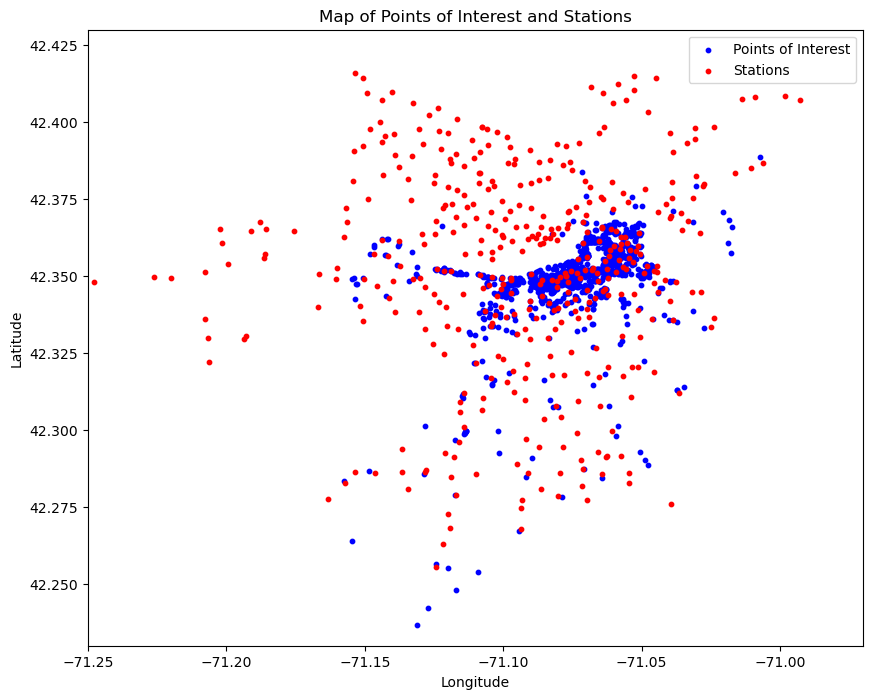

In [256]:
# We want to create a visual representation of how the stations and the points of interest are related with 
# each other geographycally 

# We create the graph
plt.figure(figsize=(10,8)) 

plt.scatter(new_pois['lon'], new_pois['lat'], color='blue', s=10, label='Points of Interest')
plt.scatter(stations['lon'], stations['lat'], color='red', s=10, label='Stations')

# We zoom in to see more details and ignore some of the outliers
lat_min, lat_max = 42.23, 42.43
lon_min, lon_max = -71.25, -70.97

filtered_amenities = new_pois[(new_pois['lat'] >= lat_min) & (new_pois['lat'] <= lat_max) &
                               (new_pois['lon'] >= lon_min) & (new_pois['lon'] <= lon_max)]

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

# We label the graph 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of Points of Interest and Stations')
plt.legend()
plt.show()

# Now we can visually see how the stations and the different points of interest are approximatetly distributed throughout the city of Boston

In [257]:
# analysis of the graph:
# we can observe that the blue dots are much more concentrated in a much smaller area while the red dots are much more disperse
# this tells us that the majority of points of interested are probably located in more centric and urban areas
# and thus the stations around those areas have a much better access to services such as transport, supermarkets, etc.

# another thing to highlight is that in the north and west areas there are much less services and amenities (we can barely
# see any blue dots) while in the south and east of the city seems to be more
# we don't know what could be te possible explanation for that but we think is important to mention since
# there is clearly an pattern 


# this information leads us to the next hypothesis:
# there is a negative correlation between density of points of interest in a concrete area
# and the idle time of the stations in that area

# to see if that is the case and test our hypothesis we are going to use a density-based measure technique 
# to calculate the density of the points of interest and see how that correlates to the idle time

# then we will analyse some statistical measures to see if our conclusions can be extrapolated to the population 
# and we can reject the null hypothesis that says that there is no relationship between the variables

# the steps are the following:

#### 1) Calculate the density of points of interest around each bike station

In [258]:
# First we need to define the haversine function:

def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371  # radius of the Earth in kilometers

# Convert latitudes and longitudes from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

# Calculate differences
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

# Haversine formula
    a = math.sin(delta_lat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

# Calculate distance
    distance = r * c
    return distance

In [259]:
# Define the radius for calculating density:

radius = 0.5

In [260]:
# Calculate the distance between each bike station and all points of interest using the haversine_distance function

stations_coords = stations[['lat', 'lon']].values
pois_coords = new_pois[['lat', 'lon']].values

distances = np.zeros((stations_coords.shape[0], pois_coords.shape[0]))

for i in range(stations_coords.shape[0]):
    for j in range(pois_coords.shape[0]):
        lat1, lon1 = stations_coords[i]
        lat2, lon2 = pois_coords[j]
        distances[i, j] = haversine_distance(lat1, lon1, lat2, lon2)

In [261]:
# Count the number of points of interest within the specified radius for each bike station:

density = np.sum(distances <= radius, axis=1)

#### 2) Add the density information to the data frame

In [262]:
# We add the variable density to the data frame stations

stations['density'] = density
stations

,station_id,lat,lon,idle_time_sum,idle_time_mean,daily_idle_time_mean,total_trips,avg_daily_trips,density
0,1,42.387151,-71.075978,1187696,3546.0,2043.675388,246,1.430233,0
1,3,42.340115,-71.100619,4228939,459.0,791.496659,8737,24.002747,36
2,4,42.345392,-71.069616,6979461,569.0,833.181883,12077,33.178571,72
3,5,42.341814,-71.090179,2924994,201.0,364.187578,14356,78.021739,21
4,6,42.361257,-71.065287,4716417,225.0,655.532480,21212,58.115068,109
...,...,...,...,...,...,...,...,...,...
422,548,42.268100,-71.119240,8689,1242.0,8880.000000,5,1.250000,0
423,549,42.364739,-71.059349,1678659,622.0,716.782809,2738,29.760870,88
424,550,42.386400,-71.096010,167922,639.0,962.149411,432,5.468354,0
425,553,42.371141,-71.076198,567219,1045.0,562.259964,699,11.095238,1


#### 3) Analyze the relationship between density and idle time, total trips or average daily trips

In [93]:
# Visualize the relationship between the density of points of interest and the idle time of stations using 
# scatter plots 

# First we are going to analyse the sum of the different idle times and compare them with the density

# Convert timedelta of the variable idle_time _sun to total hours

stations['idle_time_sum_hours'] = stations['idle_time_sum'].dt.total_seconds() / 60 / 60

# Customize scatter plot
plt.scatter(stations['density'], stations['idle_time_sum_hours'], alpha=0.7)
plt.xlabel('Density')
plt.ylabel('Idle Time (Hours)')
plt.title('Relationship between Density and Idle Time')

# Add regression line
sns.regplot(x='density', y='idle_time_sum_hours', data=stations, scatter=False, color='r')

# Set custom limits for x-axis and y-axis
x_min, x_max = 0, 200  # Adjust the range according to your data
y_min, y_max = 0, 100000  # Adjust the range according to your data
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()


#something here is not correct (the idle time doesn't make sense)


AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
# amalysis: 
# as we saw in the previous graph, we can see that there are a lot of areas that have a really low density of
# amenities, services, etc. 
# meanwhile we can see that in those same areas there are stations that still being used (or have lower idle times)
# the results seems to contradict our hypothesis that higher density leads to lower idle time (negative relation between 
# the variables) 
# why those results contradit our hypothesis? maybe because we are using absolute values? variance worth analysing


In [ ]:
# We do the same but now with idle_time_mean

# Customize scatter plot
plt.scatter(stations['density'], stations['idle_time_mean'], alpha=0.7)
plt.xlabel('Density')
plt.ylabel('Idle Time Mean')
plt.title('Relationship between Density and Idle Time')

# Add regression line
sns.regplot(x='density', y='idle_time_mean', data=stations, scatter=False, color='r')

# Set custom limits for x-axis and y-axis
x_min, x_max = 0, 350  # Adjust the range according to your data
y_min, y_max = 0, 3000  # Adjust the range according to your data
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

In [ ]:
# analysis of the graph with the mean
# why are different the relations when we use absolute values vs. means? possible explanations?
# interpretation of the results -> clearly negative relation: the higher the density the lower the idle time
# that translates that in centric / urban areas with more services and amentities
# the usage of bikes is much higher than in the suburbs

#### 4) Perform statistical analysis

In [ ]:
# next step is to investigate the relationship between density and idle time statistically
# we can calculate correlation coefficients and perform a statistical significance test


# Convert timedelta to total seconds
stations['idle_time_sum_seconds'] = stations['idle_time_sum'].dt.total_seconds()

# Calculate correlation coefficient and p-value
correlation_sum, p_value_sum = pearsonr(stations['density'], stations['idle_time_sum_seconds'])
correlation_mean, p_value_mean = pearsonr(stations['density'], stations['idle_time_mean'])


print("Correlation Coefficient (Idle Time Sum):", correlation_sum)
print("p-value (Idle Time Sum):", p_value_sum)
print("Correlation Coefficient (Idle Time Mean):", correlation_mean)
print("p-value (Idle Time Mean):", p_value_mean)


# Categorize the timedelta variable
idle_time_categories = pd.cut(stations['idle_time_sum'].dt.total_seconds(), bins=[0, 3600, 7200, 86400, float('inf')], labels=['<1 hour', '1-2 hours', '2-24 hours', '>24 hours'])

# Calculate Pearson's correlation coefficient
correlation_sum, p_value_sum = pearsonr(stations['density'], stations['idle_time_sum'].dt.total_seconds())

correlation_sum, p_value_sum = pearsonr(stations['density'], stations['idle_time_mean'])



print("Pearson's Correlation Coefficient (Idle Time Sum):", correlation_sum)
print("p-value (Idle Time Sum):", p_value_sum)

# Calculate Spearman's rank correlation coefficient
correlation_mean, p_value_mean = spearmanr(stations['density'], stations['idle_time_mean'])
print("Spearman's Rank Correlation Coefficient (Idle Time Mean):", correlation_mean)
print("p-value (Idle Time Mean):", p_value_mean)

# Create contingency table
contingency_table = pd.crosstab(stations['density'], idle_time_categories)

# Perform chi-square test
chi2, p_value_chi2, _, _ = chi2_contingency(contingency_table)
print("Chi-square statistic:", chi2)
print("p-value (Chi-square Test):", p_value_chi2)

In [ ]:
# is really weird that both correlations are different (one indicates a positive relation and the other a negative)
#A potential explanation for this discrepancy could be the presence of outliers or extreme values in the data. 
# Outliers can have a disproportionate impact on the mean and potentially result in a negative correlation with density,
# whereas the sum might be less affected by outliers and exhibit a positive correlation
# To investigate this further, you can examine the distribution of the idle_time values and check for any unusual 
# patterns or outliers. Additionally, you could consider calculating other summary statistics 
# (e.g., median, standard deviation) to gain a better understanding of the data

# but the results are not that significant, 0.22 or -0.18 is not a really high correlation
# that means that it could be other variables that can explain better the changes in idle time (like
# the variable weather as we are going to explore further in the project)


# choosing a  significance level (α) of 0.05 to determine statistical significanc
# we can see that those p-value are smaller than the significance level, so we can reject the null hypothesis 
# that says that there is not relation between both variables and conclude that there is a statistically significant 
# relationship between the variable



# Pearson's Correlation Coefficient (Idle Time Sum): The Pearson's correlation coefficient of 0.229 
# suggests a positive correlation, indicating a weak positive relationship between the density and 
# idle_time_sum variables. The p-value of 1.6367690302650741e-06 is very small, suggesting that this 
# correlation is statistically significant.

# Spearman's Rank Correlation Coefficient (Idle Time Mean):The Spearman's rank correlation coefficient 
# of -0.445 indicates a moderate negative correlation between the density and idle_time_mean variables. 
# The p-value of 3.539609614570361e-22 is extremely small, indicating that this correlation is highly 
# statistically significant.

# Chi-square Test: The chi-square statistic of 0.0 suggests that there is no association between the density 
# categories and the idle_time_sum categories. The p-value of 1.0 confirms this finding, indicating that there 
# is no statistically significant relationship between the two variables.

## Weather and idle time 

### Temperature

In [ ]:
bikes.rename(columns={'start_time':'timestamp'}, inplace=True)

In [ ]:
#here we calculate the bike idle time average for every day to see when the idle time was highest (season, weather ...)

bikes_idle_avg = bikes.groupby(pd.PeriodIndex(bikes['timestamp'], freq="D"))['idle_time'].mean() 

bikes_idle_avg


# idle time should be integer instead of delta time

In [ ]:
#here we calculate the weather average for every week, to merge it with the average idle time 

weather_temp_avg = weather.groupby(pd.PeriodIndex(weather['timestamp'], freq="D"))['temperature'].mean() 
weather_temp_avg

In [ ]:
# merged table for weather and bikes idle time average

avg = weather_temp_avg.to_frame().join(bikes_idle_avg)
avg

In [ ]:
avg['idle_hours'] = avg['idle_time'] / pd.Timedelta(hours=1)
avg

In [ ]:
xp = avg['idle_hours'].values
yp = avg['temperature'].values
plt.figure(figsize = (8,6))
plt.scatter(yp, xp, marker="x")
plt.xlabel("Temperature (°C)")
plt.ylabel("Idle_time (in Hours)")
plt.show()

In [ ]:
def plot_regression_poly(x, y, d):
    
    # create polynomial features
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x)-1  # standardize to range [-1,1]
    X = np.array([xs**i for i in range(d,-1,-1)]).T # start at highest polynomial degree (d) and go backwards until 0 in steps of 1
    
    # implement polynomial regression using least squares (we use the normal equations as derived in the lecture)
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    
    # create scaled test dataset
    xt0 = np.linspace(min_x-1, max_x+1, 400) # generate equally spaced x values in the x range
    xt = 2 * (xt0 - min_x)/(max_x - min_x) -1 # standardize to range [-1,1]
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T # generate polynomial features
    yt = Xt @ theta # generate predicted y values
    
    # plot results
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Idle_time In Hours)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:7]) # print first 7 thetas
    
plot_regression_poly(x = xp, y=yp, d = 2)


In [ ]:
correlation = avg['idle_hours'].corr(avg['temperature'])
correlation

In [94]:
# high negative correlation

In [95]:
x = avg['temperature']
y = avg['idle_hours']
corr_coeff, p_value = stats.pearsonr(x, y)

p_value

NameError: name 'avg' is not defined

In [96]:
# really small p value -> that means the results are significant

## Predictive Model

In [97]:
# Step 1: Aggregate the bike usage data to daily level
daily_bike_usage = bikes.resample('D', on='start_time').count().reset_index()
daily_bike_usage = daily_bike_usage[['start_time', 'bike_id']]
daily_bike_usage.columns = ['date', 'total_trip_count']

daily_bike_usage

,date,total_trip_count
0,2021-01-01,1884
1,2021-01-02,1712
2,2021-01-03,1480
3,2021-01-04,1921
4,2021-01-05,2025
...,...,...
360,2021-12-27,2178
361,2021-12-28,2408
362,2021-12-29,2858
363,2021-12-30,2182


In [98]:
# Step 2: Impute or aggregate the weather data to daily level
# For example, if your weather data has timestamps and you want to calculate daily averages:

weather['timestamp'] = pd.to_datetime(weather['timestamp'])

daily_weather = weather.resample('D', on='timestamp').mean().reset_index()

# Step 3: Aggregate the weather data to daily level

daily_weather = weather.resample('D', on='timestamp').mean().reset_index()

# Step 4: Merge the aggregated data
combined_data = pd.merge(daily_bike_usage, daily_weather, left_on='date', right_on='timestamp', how='left')
combined_data.drop(columns=['timestamp'], inplace=True)

C:\Users\Laura\AppData\Local\Temp\ipykernel_5072\2798707525.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_weather = weather.resample('D', on='timestamp').mean().reset_index()
C:\Users\Laura\AppData\Local\Temp\ipykernel_5072\2798707525.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_weather = weather.resample('D', on='timestamp').mean().reset_index()


#### Feature Engineering 

In [99]:
# Date Features
combined_data['day_of_week'] = combined_data['date'].dt.dayofweek
combined_data['month'] = combined_data['date'].dt.month
combined_data['season'] = combined_data['date'].dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'})

weather_features = ['temperature', 'cloud_cover', 'pressure', 'windspeed', 'precipitation', 'felt_temperature']

combined_data.dropna(inplace=True)

In [102]:
combined_data

,date,total_trip_count,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,day_of_week,month,season
0,2021-01-01,1884,0.913043,30.739130,1029.523478,11.956522,0.000000,-2.608696,4,1,Winter
1,2021-01-02,1712,3.772727,17.272727,1013.002273,20.704545,0.536591,-0.477273,5,1,Winter
2,2021-01-03,1480,0.551724,23.586207,1018.985172,15.137931,0.017241,-3.931034,6,1,Winter
3,2021-01-04,1921,1.000000,24.333333,1015.070606,19.424242,0.023030,-4.272727,0,1,Winter
4,2021-01-05,2025,-0.250000,20.777778,1012.522778,17.583333,0.006944,-5.250000,1,1,Winter
...,...,...,...,...,...,...,...,...,...,...,...
360,2021-12-27,2178,0.640000,28.720000,1015.505200,18.160000,0.000000,-4.000000,0,12,Winter
361,2021-12-28,2408,2.648649,17.351351,1009.614324,9.135135,0.040541,0.270270,1,12,Winter
362,2021-12-29,2858,4.862069,26.068966,1012.345517,6.896552,0.000000,3.517241,2,12,Winter
363,2021-12-30,2182,4.555556,17.583333,1013.998333,4.638889,0.063333,3.500000,3,12,Winter


In [100]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              365 non-null    datetime64[ns]
 1   total_trip_count  365 non-null    int64         
 2   temperature       365 non-null    float64       
 3   cloud_cover       365 non-null    float64       
 4   pressure          365 non-null    float64       
 5   windspeed         365 non-null    float64       
 6   precipitation     365 non-null    float64       
 7   felt_temperature  365 non-null    float64       
 8   day_of_week       365 non-null    int64         
 9   month             365 non-null    int64         
 10  season            365 non-null    object        
dtypes: datetime64[ns](1), float64(6), int64(3), object(1)
memory usage: 34.2+ KB


In [101]:
# since is really difficult to merge both df (the one with the weather info and the other one with the station/ location
# info) due to the lack of a link between both df, we think is better to create two different predictive models


### Algorithm 1: Predicting Total Trips based on Station Information

In [56]:
# Step 1.1: Prepare Data for Algorithm 1

# Select the station-specific features for Algorithm 1
station_features = stations[['station_id', 'idle_time_sum', 'idle_time_mean', 'density']]

# Split the data into features (X) and target variable (y)
X_station = station_features.drop('station_id', axis=1)  # Remove station_id as it's not a feature
y_station = station_features['station_id']  # Target variable is the station_id

# Now, X_station contains the station-specific features (idle_time_sum, idle_time_mean, density),
# and y_station contains the corresponding station_ids.

# Split the data into training and testing sets
# Use appropriate methods for splitting time series data if applicable (e.g., by using the most recent data for testing)
# For example, you can use train_test_split from scikit-learn for random splitting:

X_train_station, X_test_station, y_train_station, y_test_station = train_test_split(X_station, y_station, test_size=0.2, random_state=42)

# Proceed with Algorithm 1 and choose a regression model, train, and evaluate it as mentioned earlier.
# For example, you can use Linear Regression as the model:

model_station = LinearRegression()
model_station.fit(X_train_station, y_train_station)

# Evaluate the model's performance on the testing data
y_pred_station = model_station.predict(X_test_station)

# Perform evaluation using appropriate regression metrics (e.g., Mean Absolute Error, Mean Squared Error)
# For example, using Mean Absolute Error (MAE):

mae_station = mean_absolute_error(y_test_station, y_pred_station)
print("Mean Absolute Error for Algorithm 1:", mae_station)

Mean Absolute Error for Algorithm 1: 126.55506229928223


### Algorithm 2: Predicting Total Trips based on Weather Information

In [57]:
# Step 1.2: Prepare Data for Algorithm 2

# Select the weather features for Algorithm 2
weather_features = combined_data[['temperature', 'cloud_cover', 'pressure', 'windspeed', 'precipitation', 'felt_temperature', 'day_of_week', 'month']]

# Split the data into features (X) and target variable (y)
X_weather = weather_features  # Use all weather features as inputs
y_weather = combined_data['total_trip_count']  # Target variable is the total_trip_count

# Now, X_weather contains the weather-related features (temperature, cloud_cover, pressure, etc.),
# and y_weather contains the corresponding total_trip_count.

# Split the data into training and testing sets
# Use appropriate methods for splitting time series data if applicable (e.g., by using the most recent data for testing)
# For example, you can use train_test_split from scikit-learn for random splitting:

X_train_weather, X_test_weather, y_train_weather, y_test_weather = train_test_split(X_weather, y_weather, test_size=0.2, random_state=42)

# Proceed with Algorithm 2 and choose a regression model, train, and evaluate it as mentioned earlier.
# For example, you can use Linear Regression as the model:

model_weather = LinearRegression()
model_weather.fit(X_train_weather, y_train_weather)

# Evaluate the model's performance on the testing data
y_pred_weather = model_weather.predict(X_test_weather)

# Perform evaluation using appropriate regression metrics (e.g., Mean Absolute Error, Mean Squared Error)
# For example, using Mean Absolute Error (MAE):

mae_weather = mean_absolute_error(y_test_weather, y_pred_weather)
print("Mean Absolute Error for Algorithm 2:", mae_weather)

Mean Absolute Error for Algorithm 2: 1646.2269094484182


### Step 2: Evaluate the Models

In [58]:
# Step 2.1: Evaluate Model for Algorithm 1
from sklearn.metrics import mean_absolute_error

y_pred_station = model_station.predict(X_test_station)
mae_station = mean_absolute_error(y_test_station, y_pred_station)
print("Mean Absolute Error for Algorithm 1:", mae_station)

# Step 2.2: Evaluate Model for Algorithm 2
y_pred_weather = model_weather.predict(X_test_weather)
mae_weather = mean_absolute_error(y_test_weather, y_pred_weather)
print("Mean Absolute Error for Algorithm 2:", mae_weather)

Mean Absolute Error for Algorithm 1: 126.55506229928223
Mean Absolute Error for Algorithm 2: 1646.2269094484182


### Make predictions